Import the relevant libraries

#import relevant libraries

#general
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet')

#machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#preprocessing and pipleline
from sklearn.pipeline import Pipeline

from collections import Counter

In [164]:
#general libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings

#suppress all warnings
warnings.filterwarnings('ignore')

#NLP libraries
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

#Machine Learning libraries
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#model evaluation libraries
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

#preprocessing and pipeline libraries
from sklearn.pipeline import Pipeline

#other libraries
from collections import Counter

In [90]:
#pull in the data 
df= pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
#preview the data
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [92]:
raw_df= df[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]
raw_df= raw_df.dropna()
raw_df = raw_df.drop_duplicates(keep='first')
raw_df = raw_df.rename(columns={'tweet_text': 'tweet', 
                                'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})
raw_df['emotion'].value_counts(normalize= True)

emotion
No emotion toward brand or product    0.592613
Positive emotion                      0.327453
Negative emotion                      0.062734
I can't tell                          0.017200
Name: proportion, dtype: float64

In [93]:
rel_raw_df = raw_df[raw_df['emotion'] != "I can't tell"]


sentiment_map = {'No emotion toward brand or product': 0,
    'Positive emotion': 1,
    'Negative emotion': 0}
rel_raw_df['sentiment'] = rel_raw_df['emotion'].map(sentiment_map)


rel_raw_df['sentiment'].value_counts(normalize= True)

sentiment
0    0.666816
1    0.333184
Name: proportion, dtype: float64

In [94]:
rel_raw_df["tweet"] = rel_raw_df["tweet"].str.lower()
rel_raw_df[:10]

,tweet,emotion,sentiment
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Negative emotion,0
1,@jessedee know about @fludapp ? awesome ipad/i...,Positive emotion,1
2,@swonderlin can not wait for #ipad 2 also. the...,Positive emotion,1
3,@sxsw i hope this year's festival isn't as cra...,Negative emotion,0
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Positive emotion,1
5,@teachntech00 new ipad apps for #speechtherapy...,No emotion toward brand or product,0
7,"#sxsw is just starting, #ctia is around the co...",Positive emotion,1
8,beautifully smart and simple idea rt @madebyma...,Positive emotion,1
9,counting down the days to #sxsw plus strong ca...,Positive emotion,1
10,excited to meet the @samsungmobileus at #sxsw ...,Positive emotion,1


In [95]:
#9092 is a nonsensical symbolized tweet, drop it
"""
'\x8cï¡\x8eïà\x8aü_\x8b\x81ê\x8b\x81î\x8b\x81ò\x8b\x81£\x8b
\x81á\x8bââ\x8b\x81_\x8b\x81£\x8b\x81\x8f\x8bâ_\x8bûârt 
@mention google tests \x89ûïcheck-in offers\x89û\x9d at 
#sxsw {link}'
"""

rel_raw_df= rel_raw_df.drop(9092)

In [96]:
#removing usernames
rel_raw_df["tweet"]= rel_raw_df["tweet"].apply(lambda x : ' '.join(
    [w for w in x.split() if '@' not in w]).strip())

#removing hashtags
rel_raw_df["tweet"]= rel_raw_df["tweet"].apply(lambda x : ' '.join(
    [w for w in x.split() if '#' not in w]))

#use ReGex to strip the tweets down to only what we want
def strip_token(tweet):
    tweet = re.sub(r'http[s]?://\S+|www\.\S+', '', tweet) #remove all links form tweets
    tweet = re.sub(r'&amp;', 'and', tweet) #convert all instances of '&amp' to 'and'
    tweet = re.sub(r"'", "", tweet) #removes " ' " converting "can't" to "cant"
    tweet = re.sub(r'_', ' ', tweet) #removes all '_' from tweets
    tweet = re.sub(r'[^\w\s]', ' ', tweet) #removes all non word characters from tweets
    tweet = re.sub(r'\d+\w*', '', tweet) #removes all numbers or character combinations that begin with numbers 
    tweet = re.sub(r'can not', "cant", tweet) #convert all instances of 'can not' to 'cant'
    tweet = re.sub(r'will not', "wont", tweet) #convert all instances of 'will not' to 'wont'
    tweet = re.sub(r'do not', "dont", tweet) #convert all instances of 'do not' to 'dont'
    tweet = re.sub(r'\b[^a-zA-Z]+', ' ', tweet) #should strip all non standard a-z characters left over 
    tokens = word_tokenize(tweet)
    return tokens
rel_raw_df['tweet_tokenized'] = rel_raw_df['tweet'].apply(strip_token)

#preview dataset
rel_raw_df[['sentiment', 'tweet_tokenized']]

,sentiment,tweet_tokenized
0,0,"[i, have, a, iphone, after, hrs, tweeting, at,..."
1,1,"[know, about, awesome, ipad, iphone, app, that..."
2,1,"[cant, wait, for, also, they, should, sale, th..."
3,0,"[i, hope, this, years, festival, isnt, as, cra..."
4,1,"[great, stuff, on, fri, marissa, mayer, google..."
...,...,...
9087,0,"[yup, but, i, dont, have, a, third, app, yet, ..."
9088,1,"[ipad, everywhere, link]"
9089,0,"[wave, buzz, rt, we, interrupt, your, regularl..."
9090,0,"[googles, zeiger, a, physician, never, reporte..."


In [97]:
#lemmetize the tokens
lemmatizer = WordNetLemmatizer()

def lem_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

rel_raw_df['tweet_lem'] = rel_raw_df['tweet_tokenized'].apply(lem_tokens)

In [98]:
X= rel_raw_df['tweet_lem']
y= rel_raw_df['sentiment']

#Train/remain split ("remain" is the remaining data)
X_train, X_remain, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val/test split 
X_val, X_test, y_val, y_test= train_test_split(X_remain, y_remain,
                                               test_size= 0.5, 
                                               random_state= 24)

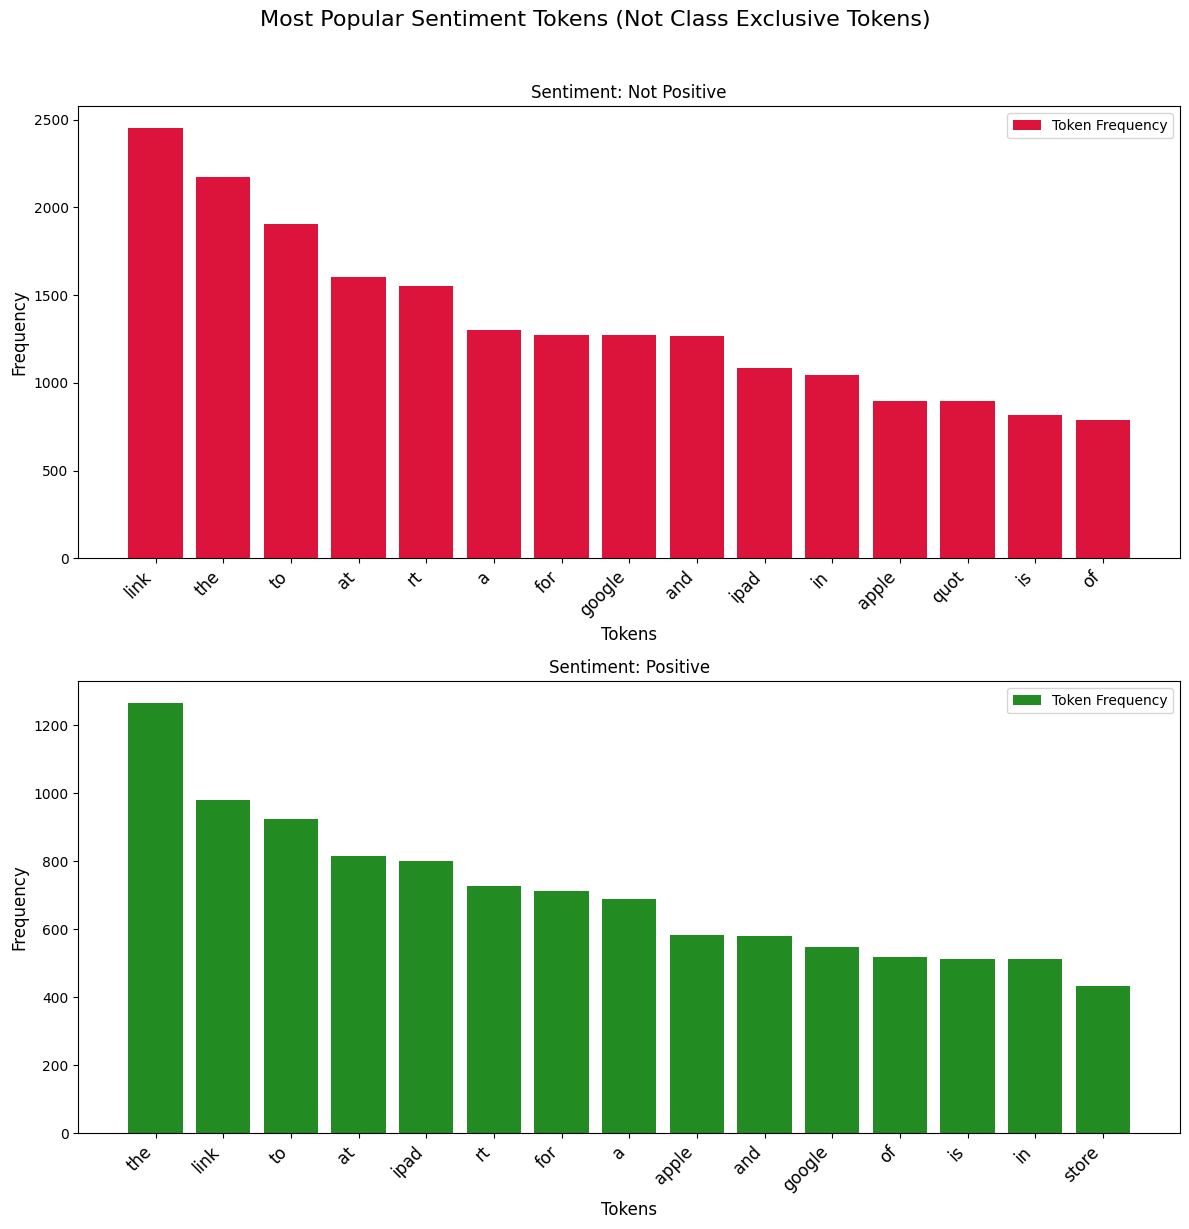

In [146]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))

sentiment_colors = {0: 'crimson', 1: 'forestgreen'}
sentiment_labels = {0: 'Not Positive', 1: 'Positive'}

sentiment_classes = sorted(y_train.unique())

for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train[y_train == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    top_15 = Counter(all_words_in_sentiment).most_common(15)  
    
    ax = axes[i]
    words, counts = zip(*top_15) if top_15 else ([], [])
    ax.bar(words, counts, color=sentiment_colors[sentiment_class], label='Token Frequency')
    ax.set_title(f'Sentiment: {sentiment_labels[sentiment_class]}')
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize= 12)
    ax.set_xlabel('Tokens', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(loc='best', fontsize=10)

fig.suptitle('Most Popular Sentiment Tokens (Not Class Exclusive Tokens)', fontsize=16, y=1.02)

fig.tight_layout()

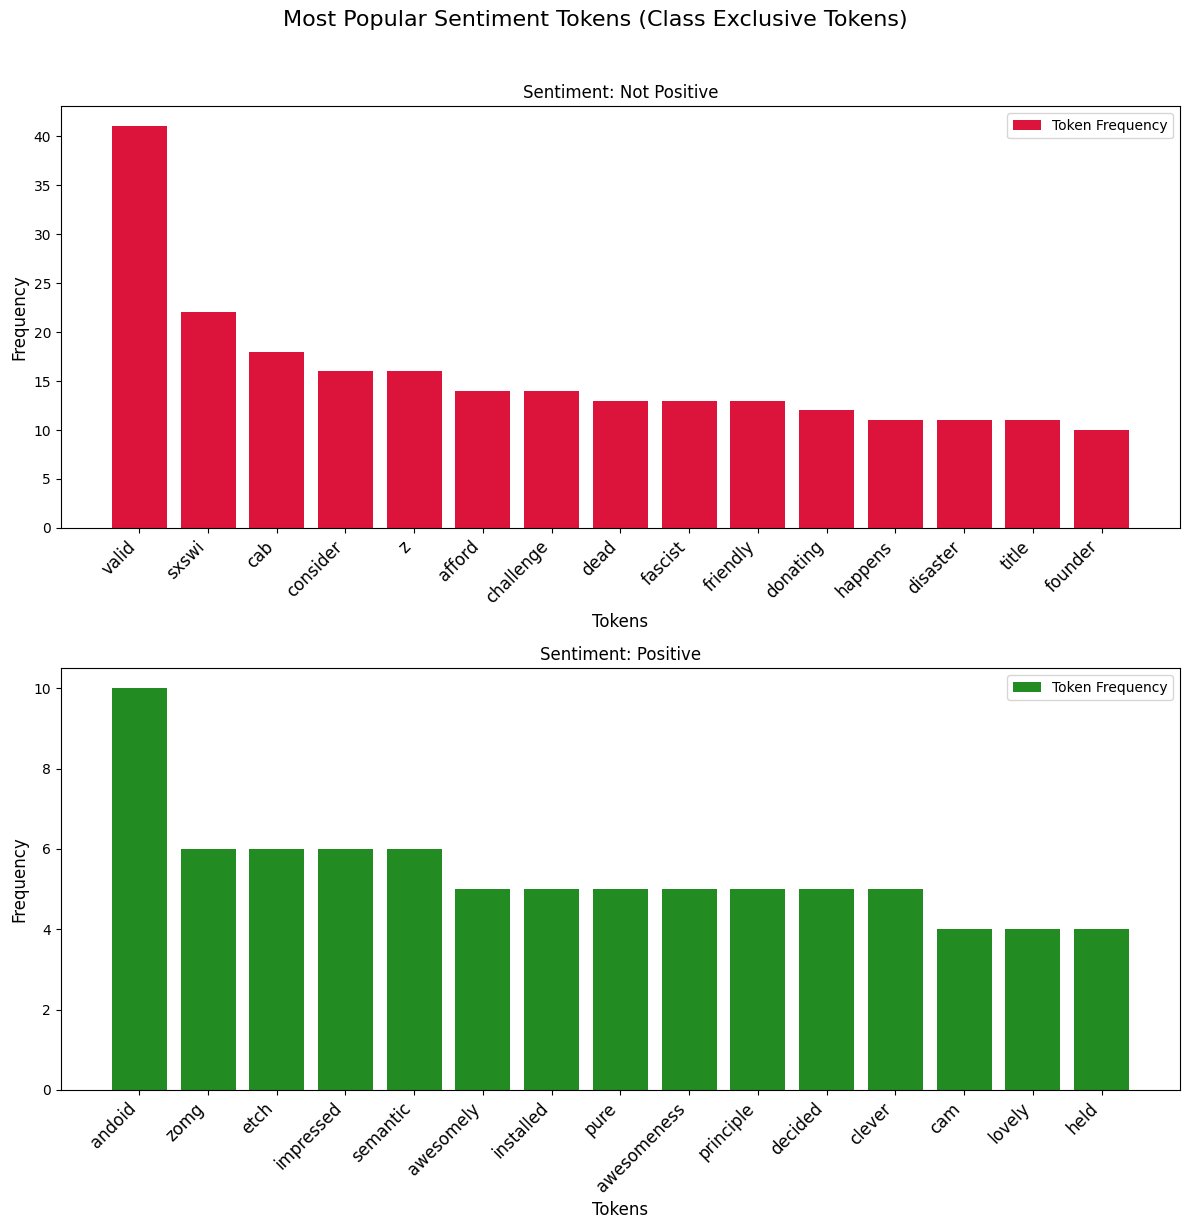

In [147]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))

sentiment_colors = {0: 'crimson', 1: 'forestgreen'}
sentiment_labels = {0: 'Not Positive', 1: 'Positive'}

sentiment_classes = sorted(y_train.unique())

words_by_sentiment = {}
for sentiment_class in sentiment_classes:
    sentiment_data = X_train[y_train == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    words_by_sentiment[sentiment_class] = set(all_words_in_sentiment)

unique_words_by_sentiment = {}
for sentiment_class in sentiment_classes:
    other_classes = [s for s in sentiment_classes if s != sentiment_class]
    other_words = set()
    for other_class in other_classes:
        other_words.update(words_by_sentiment[other_class])
    unique_words = words_by_sentiment[sentiment_class] - other_words
    unique_words_by_sentiment[sentiment_class] = unique_words

for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train[y_train == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    unique_words_in_sentiment = [word for word in all_words_in_sentiment if word in unique_words_by_sentiment[sentiment_class]]
    top_15 = Counter(unique_words_in_sentiment).most_common(15)
    
    ax = axes[i]
    words, counts = zip(*top_15) if top_15 else ([], [])
    ax.bar(words, counts, color=sentiment_colors[sentiment_class], label='Token Frequency')
    ax.set_title(f'Sentiment: {sentiment_labels[sentiment_class]}')
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize= 12)
    ax.set_xlabel('Tokens', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(loc='best', fontsize=10)

fig.suptitle('Most Popular Sentiment Tokens (Class Exclusive Tokens)', fontsize=16, y=1.02)

fig.tight_layout()

## Model Building

In [22]:
 # Join token lists into strings
X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

print(f"X_train Example: {X_train[0]}\n")
print(f"X_train_str Example: {X_train_str[0]}") 

X_train Example: ['i', 'have', 'a', 'iphone', 'after', 'hr', 'tweeting', 'at', 'it', 'wa', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'station', 'at']

X_train_str Example: i have a iphone after hr tweeting at it wa dead i need to upgrade plugin station at


In [14]:
stopwords_list= stopwords.words('english')
stopwords_list = [word for word in stopwords_list if word not in ['not', 'can']]
#possibly append words to the list of stop words
additional_stopwords= ['google', 'iphone', 'ipad', 'link', 'apple', 'rt', 'store', 'quot', 'austin', 'via', 'sxsw']
stopwords_list2= stopwords_list + additional_stopwords

### Baseline Model - Multinomial Niave Bayes

#### Un-Tuned Multinomial Niave Bayes

Baseline Train Cross-Validation Score (MultinomialNB): 0.6979
Baseline Validation Set Accuracy (MultinomialNB): 0.7228


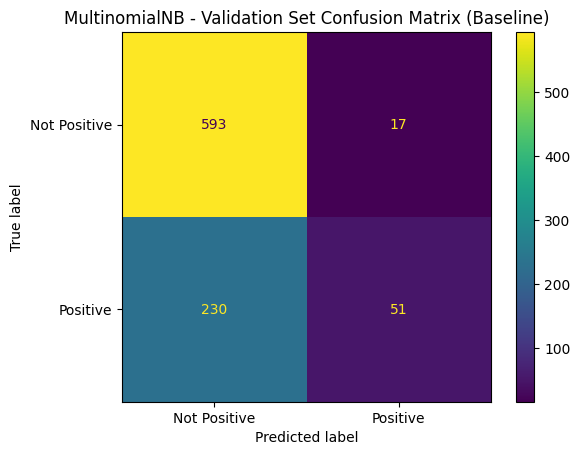

In [24]:
baseline_MNB_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())])

baseline_MNB_pipe.fit(X_train_str, y_train)

y_val_pred = baseline_MNB_pipe.predict(X_val_str)

BMNB_val_accuracy = accuracy_score(y_val, y_val_pred)

baseline_MNB_train_cv_score = cross_val_score(baseline_MNB_pipe, X_train_str, y_train, cv=5, scoring='accuracy').mean()

print(f"Baseline Train Cross-Validation Score (MultinomialNB): {baseline_MNB_train_cv_score:.4f}")
print(f"Baseline Validation Set Accuracy (MultinomialNB): {BMNB_val_accuracy:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
BMNB_matrix = ConfusionMatrixDisplay(cm_val, display_labels=['Not Positive', 'Positive'])
BMNB_matrix.plot()
plt.title("MultinomialNB - Validation Set Confusion Matrix (Baseline)")
plt.show()

#### Multinomial Niave Bayes Grid Search

Previous Best Model Results: Baseline Multinomial Naive Bayes
Baseline Train Cross-Validation Score: 0.6979
Baseline Validation Set Accuracy: 0.7228



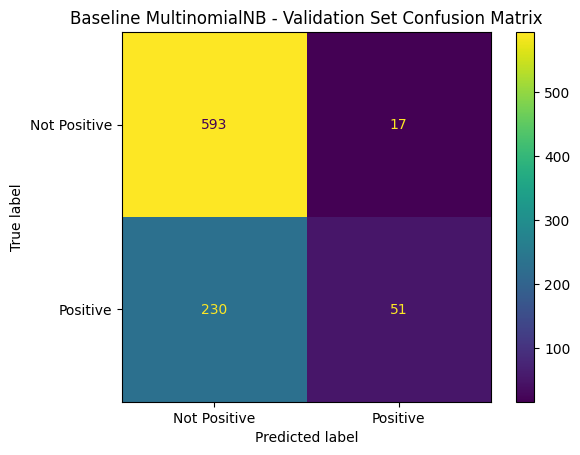

___VS___

Tuned Multinomial Niave Bayes Model Results
Best Multiple Niave Bayes Hyperparameters: {'mnb__alpha': 0.1, 'mnb__fit_prior': True, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True}

Tuned  Multiple Niave Bayes Train Cross-Validation Score: 0.7156
Tuned Validation Set Accuracy: 0.7553



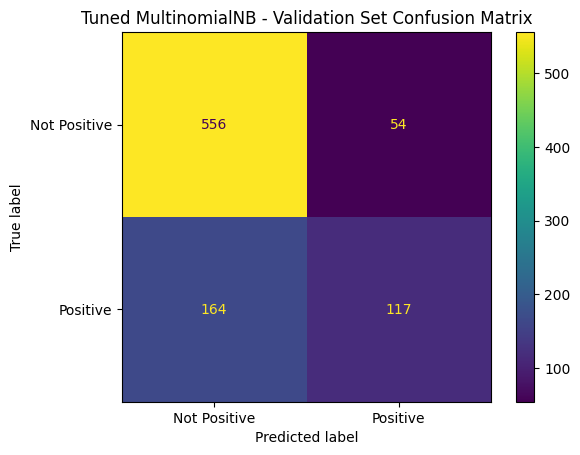

In [35]:
MNB_pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())])

#make a parameter grid
MNB_param_grid1 = {
    #
    'tfidf__max_features': [1000,2000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [0.01, 0.001,],
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__stop_words': [None, stopwords_list],
    'tfidf__sublinear_tf': [True, False],
    'mnb__alpha': [0.1, 0.01],
    'mnb__fit_prior': [True, False]}

    
#run a grid search to find the most accurate version for Multinomial Naive Bayes
MNB_grid_search1 = GridSearchCV(
    MNB_pipeline1,
    MNB_param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

MNB_grid_search1.fit(X_train_str, y_train)

MNB_best_train_cv_score = MNB_grid_search1.best_score_

MNB_best_model = MNB_grid_search1.best_estimator_

y_val_pred = MNB_best_model.predict(X_val_str)

MNB_val_accuracy = accuracy_score(y_val, y_val_pred)

MNB_best_params = MNB_grid_search1.best_params_

print("Previous Best Model Results: Baseline Multinomial Naive Bayes")
print(f"Baseline Train Cross-Validation Score: {baseline_MNB_train_cv_score:.4f}")
print(f"Baseline Validation Set Accuracy: {BMNB_val_accuracy:.4f}\n")

BMNB_matrix.plot()
plt.title("Baseline MultinomialNB - Validation Set Confusion Matrix")
plt.show()

print("___VS___\n")

print("Tuned Multinomial Niave Bayes Model Results")
print(f"Best Multiple Niave Bayes Hyperparameters: {MNB_best_params}\n")
print(f"Tuned  Multiple Niave Bayes Train Cross-Validation Score: {MNB_best_train_cv_score:.4f}")
print(f"Tuned Validation Set Accuracy: {MNB_val_accuracy:.4f}\n")

cm_val = confusion_matrix(y_val, y_val_pred)
Tuned_MNB_matrix = ConfusionMatrixDisplay(cm_val, display_labels=['Not Positive', 'Positive'])
Tuned_MNB_matrix.plot()
plt.title("Tuned MultinomialNB - Validation Set Confusion Matrix")
plt.show()

### Logistic Regression

#### Logistic Regression Grid Search

Previous Best Model Results: Tuned Multinomial Naive Bayes
Tuned  Multiple Niave Bayes Train Cross-Validation Score: 0.7156
Tuned Validation Set Accuracy: 0.7553



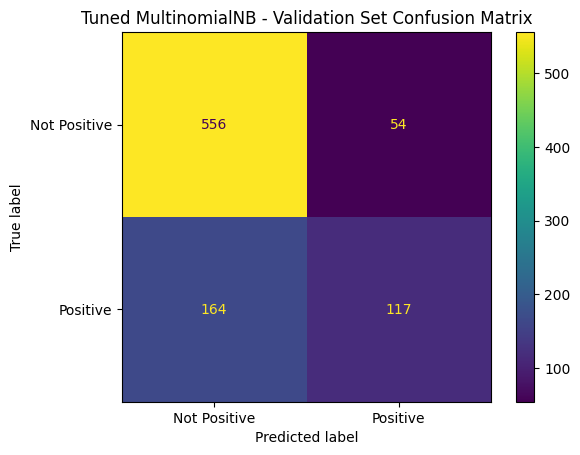

___VS___

Tuned Logistic Regression Model Results
Logistic Regression Best Hyperparameters: {'lr__C': 1, 'lr__class_weight': None, 'lr__fit_intercept': True, 'lr__solver': 'lbfgs', 'lr__tol': 1e-05, 'tfidf__max_df': 0.85, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True}
Tuned Logistic Regression Train Cross-Validation Score: 0.7296
Validation Set Accuracy: 0.7542



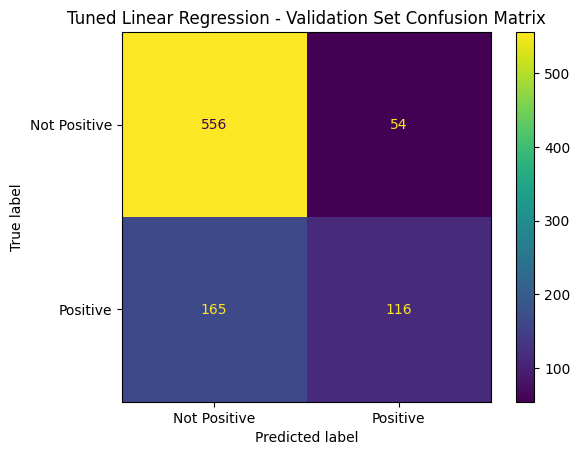

In [42]:
LR_pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=24))])
#make a parameter grid
LR_param_grid1 = {
    'tfidf__max_features': [2000, 3500],
    'tfidf__ngram_range': [(1,2), (1,3)],
    'tfidf__min_df': [0.0, 1],
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__stop_words': [stopwords_list2, 'english'],
    'tfidf__sublinear_tf': [True, False],
    'lr__C': [1, 0.1],
    'lr__fit_intercept': [True, False],
    'lr__class_weight': [None, {0: 1, 1: 1.5}],
    'lr__solver': ['liblinear', 'lbfgs'],
    'lr__tol': [1e-5, 1e-6]}

    
#run a grid search to find the most accurate version for logistic regression
LR_grid_search1 = GridSearchCV(
    LR_pipeline1,
    LR_param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

LR_grid_search1.fit(X_train_str, y_train)

LR_best_train_cv_score = LR_grid_search1.best_score_

LR_best_model = LR_grid_search1.best_estimator_

y_val_pred = LR_best_model.predict(X_val_str)

LR_val_accuracy = accuracy_score(y_val, y_val_pred)

LR_best_params = LR_grid_search1.best_params_


print("Previous Best Model Results: Tuned Multinomial Naive Bayes")
print(f"Tuned  Multiple Niave Bayes Train Cross-Validation Score: {MNB_best_train_cv_score:.4f}")
print(f"Tuned Validation Set Accuracy: {MNB_val_accuracy:.4f}\n")

Tuned_MNB_matrix.plot()
plt.title("Tuned MultinomialNB - Validation Set Confusion Matrix")
plt.show()

print("___VS___\n")

print("Tuned Logistic Regression Model Results")
print(f"Logistic Regression Best Hyperparameters: {LR_best_params}")
print(f"Tuned Logistic Regression Train Cross-Validation Score: {LR_best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {LR_val_accuracy:.4f}\n")

cm_val = confusion_matrix(y_val, y_val_pred)
Tuned_LR_matrix = ConfusionMatrixDisplay(cm_val, display_labels=['Not Positive', 'Positive'])
Tuned_LR_matrix.plot()
plt.title("Tuned Linear Regression - Validation Set Confusion Matrix")
plt.show()

### XG Boost

#### XG Boost Grid Search

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
Previous Best Model Results: Tuned Multinomial Naive Bayes
Tuned  Multiple Niave Bayes Train Cross-Validation Score: 0.7156
Tuned Validation Set Accuracy: 0.7553



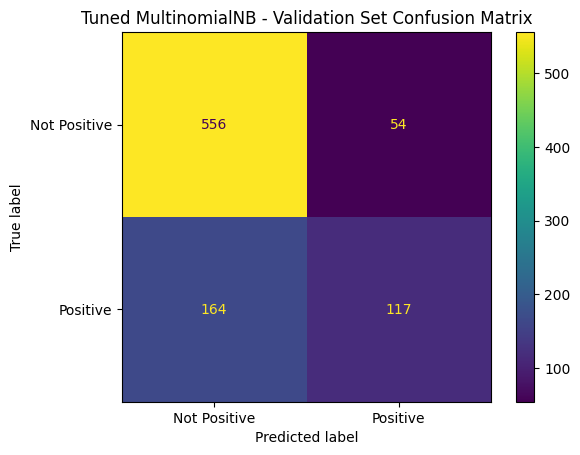

___VS___

Tuned XG Boost Model Results
Best XG Boost Hyperparameters: {'tfidf__max_df': 0.65, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 1}
Best XG Boost Train Cross-Validation Score: 0.7257
Validation Set Accuracy: 0.7677



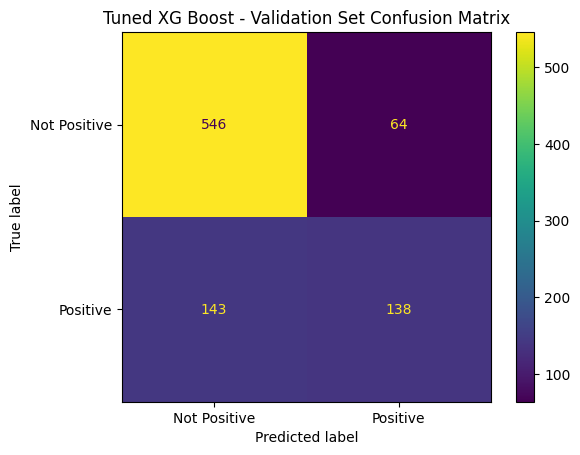

In [49]:
XGB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier(random_state=24, 
                          eval_metric='logloss'))])

XGB_param_grid = {
    'tfidf__max_features': [2000, 3500],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [ 2, 10],
    'tfidf__max_df': [0.65, 0.75],
    'tfidf__stop_words': [stopwords_list, None],
    'tfidf__sublinear_tf': [True, False],
    'xgb__n_estimators': [200, 100],
    'xgb__max_depth': [4, 5],
    'xgb__learning_rate': [0.3, 0.2],
    'xgb__scale_pos_weight': [0, 1]}

XGB_grid_search = GridSearchCV(
    XGB_pipeline,
    XGB_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1)

XGB_grid_search.fit(X_train_str, y_train)


best_train_cv_score_xgb = XGB_grid_search.best_score_
best_model_xgb = XGB_grid_search.best_estimator_
y_val_pred_xgb = best_model_xgb.predict(X_val_str)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
best_params_xgb = XGB_grid_search.best_params_

print("Previous Best Model Results: Tuned Multinomial Naive Bayes")
print(f"Tuned  Multiple Niave Bayes Train Cross-Validation Score: {MNB_best_train_cv_score:.4f}")
print(f"Tuned Validation Set Accuracy: {MNB_val_accuracy:.4f}\n")

Tuned_MNB_matrix.plot()
plt.title("Tuned MultinomialNB - Validation Set Confusion Matrix")
plt.show()

print("___VS___\n")


print("Tuned XG Boost Model Results")
print(f"Best XG Boost Hyperparameters: {best_params_xgb}")
print(f"Best XG Boost Train Cross-Validation Score: {best_train_cv_score_xgb:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_xgb:.4f}\n")

cm_val = confusion_matrix(y_val, y_val_pred_xgb)
Tuned_XGB_matrix = ConfusionMatrixDisplay(cm_val, display_labels=['Not Positive', 'Positive'])
Tuned_XGB_matrix.plot()
plt.title("Tuned XG Boost - Validation Set Confusion Matrix")
plt.show()

### Linear SVC

#### Linear SVC Grid Search

Previous Best Model Results: Tuned XG Boost
Best XG Boost Train Cross-Validation Score: 0.7257
Validation Set Accuracy: 0.7677



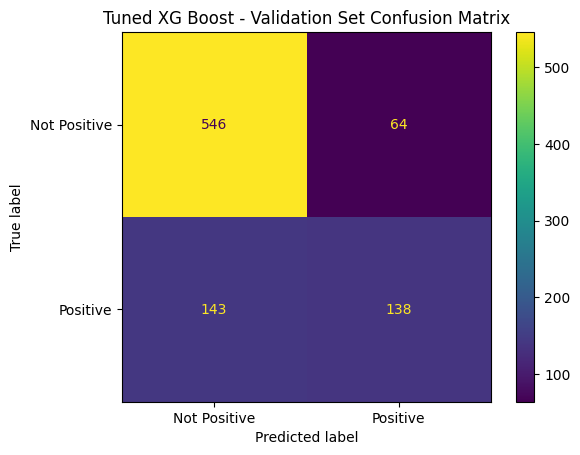

___VS___

Tuned Linear SVC Model Results
Best Linear SVC Hyperparameters: {'lsvc__C': 1, 'lsvc__loss': 'squared_hinge', 'lsvc__penalty': 'l2', 'lsvc__tol': 0.1, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True}
Tuned Linear SVC Train Cross-Validation Score: 0.7271
Validation Set Accuracy: 0.7744



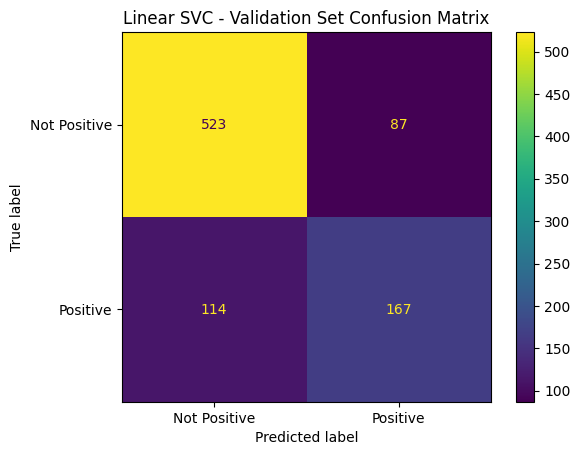

In [62]:
LSVC_pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lsvc', LinearSVC(random_state=24, 
                       dual=True))])

#make a parameter grid
LSVC_param_grid1 = {
    'tfidf__max_features': [2000, 3500],
    'tfidf__ngram_range': [(1, 1), (1,2)],
    'tfidf__min_df': [0.0, 0.01],
    'tfidf__max_df': [0.95, 0.85],
    'tfidf__stop_words': [stopwords_list, None],
    'tfidf__sublinear_tf': [True, False],
    'lsvc__C': [1,10],
    'lsvc__penalty': ['l2', 'l1'],
    'lsvc__loss': ['squared_hinge'],
    'lsvc__tol': [1e-1, 10]}

    
LSVC_grid_search1 = GridSearchCV(
    LSVC_pipeline1,
    LSVC_param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

LSVC_grid_search1.fit(X_train_str, y_train)

LSVC_best_train_cv_score = LSVC_grid_search1.best_score_

LSVC_best_model = LSVC_grid_search1.best_estimator_

y_val_pred = LSVC_best_model.predict(X_val_str)


LSVC_val_accuracy = accuracy_score(y_val, y_val_pred)

LSVC_best_params = LSVC_grid_search1.best_params_

print("Previous Best Model Results: Tuned XG Boost")
print(f"Best XG Boost Train Cross-Validation Score: {best_train_cv_score_xgb:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_xgb:.4f}\n")
Tuned_XGB_matrix.plot()
plt.title("Tuned XG Boost - Validation Set Confusion Matrix")
plt.show()

print("___VS___\n")

print("Tuned Linear SVC Model Results")
print(f"Best Linear SVC Hyperparameters: {LSVC_best_params}")
print(f"Tuned Linear SVC Train Cross-Validation Score: {LSVC_best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {LSVC_val_accuracy:.4f}\n")

cm_val = confusion_matrix(y_val, y_val_pred)
Tuned_LSVC_matrix = ConfusionMatrixDisplay(cm_val, display_labels=['Not Positive', 'Positive'])
Tuned_LSVC_matrix.plot()
plt.title("Linear SVC - Validation Set Confusion Matrix")
plt.show()

### Random Forest

#### Random Forest Grid Search

Previous Best Model Results: Tuned Linear SVC
Best Linear SVC Train Cross-Validation Score: 0.7271
Validation Set Accuracy: 0.7744



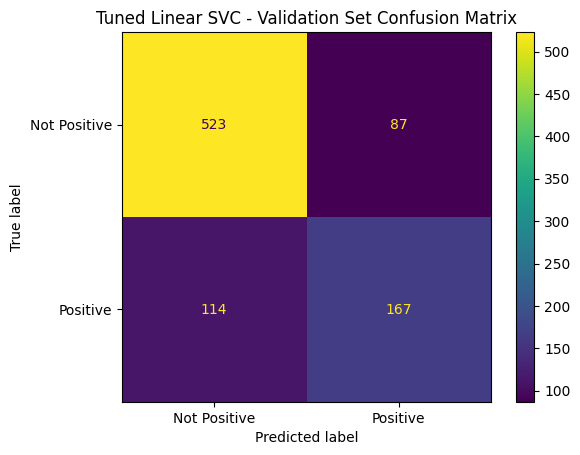

___VS___

Tuned Random Forest Classifier Results
Random Forest Classifier Best Hyperparameters: {'rfc__bootstrap': True, 'rfc__max_depth': None, 'rfc__max_features': 'sqrt', 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 150, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True}
Tuned Random Forest Classifier Train Cross-Validation Score: 0.7281
Validation Set Accuracy: 0.7643



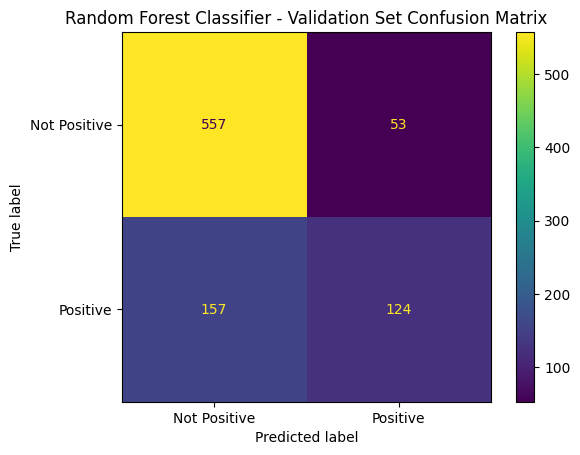

In [67]:
RF_pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rfc', RandomForestClassifier(random_state=24))])

#make a parameter grid
RF_param_grid1 = {
    'tfidf__max_features': [2000],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'rfc__n_estimators': [100, 150],
    'rfc__max_depth': [None],
    'rfc__min_samples_split': [10, 15],
    'rfc__min_samples_leaf': [1, 2],
    'rfc__max_features': ['sqrt'],
    'rfc__bootstrap': [True]}

    

RF_grid_search1 = GridSearchCV(
    RF_pipeline1,
    RF_param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)


RF_grid_search1.fit(X_train_str, y_train)


RF_best_train_cv_score = RF_grid_search1.best_score_


RF_best_model = RF_grid_search1.best_estimator_


y_val_pred = RF_best_model.predict(X_val_str)


RF_val_accuracy = accuracy_score(y_val, y_val_pred)


RF_best_params = RF_grid_search1.best_params_

print("Previous Best Model Results: Tuned Linear SVC")
print(f"Best Linear SVC Train Cross-Validation Score: {LSVC_best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {LSVC_val_accuracy:.4f}\n")
Tuned_LSVC_matrix.plot()
plt.title("Tuned Linear SVC - Validation Set Confusion Matrix")
plt.show()

print("___VS___\n")

print("Tuned Random Forest Classifier Results")
print(f"Random Forest Classifier Best Hyperparameters: {RF_best_params}")
print(f"Tuned Random Forest Classifier Train Cross-Validation Score: {RF_best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {RF_val_accuracy:.4f}\n")

cm_val = confusion_matrix(y_val, y_val_pred)
Tuned_RFC_matrix = ConfusionMatrixDisplay(cm_val, display_labels=['Not Positive', 'Positive'])
Tuned_RFC_matrix.plot()
plt.title("Random Forest Classifier - Validation Set Confusion Matrix")
plt.show()

### Gradient Boosting

#### Gradfient Boosting Grid Search

Previous Best Model Results: Tuned Linear SVC
Best Linear SVC Train Cross-Validation Score: 0.7271
Validation Set Accuracy: 0.7744



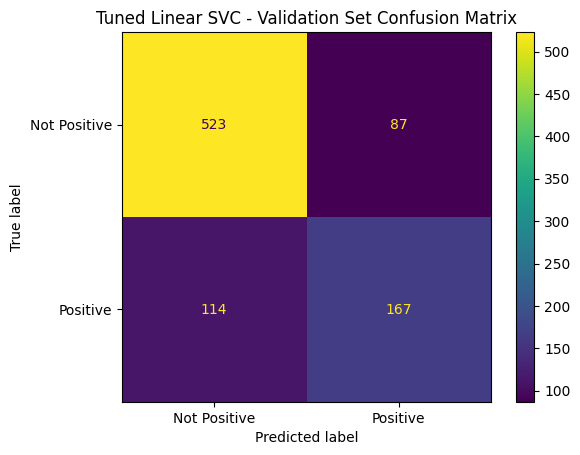

___VS___

Tuned Gradient Boosting Classifier Results
Best Gradient Boosting Classifier Hyperparameters: {'gbc__learning_rate': 0.1, 'gbc__loss': 'exponential', 'gbc__max_depth': 7, 'gbc__min_samples_leaf': 4, 'gbc__min_samples_split': 2, 'gbc__n_estimators': 300, 'gbc__subsample': 0.8, 'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Tuned Gradient Boosting Calssifier Train Cross-Validation Score: 0.7323
Validation Set Accuracy: 0.7542


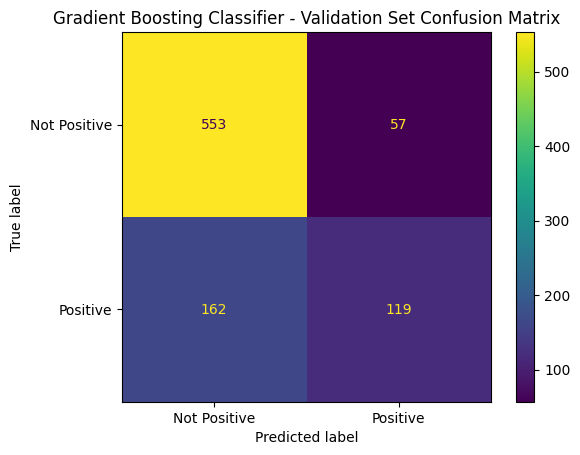

In [69]:
GB_pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('gbc', GradientBoostingClassifier(random_state=24))])

GB_param_grid1 = {
    'tfidf__max_features': [4000],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'gbc__n_estimators': [300, 400],
    'gbc__learning_rate': [0.1, 0.2],
    'gbc__max_depth': [6, 7],
    'gbc__subsample': [0.7, 0.8],
    'gbc__min_samples_split': [2, 3],
    'gbc__min_samples_leaf': [4, 5],
    'gbc__loss': ['exponential']}

GB_grid_search1 = GridSearchCV(
    GB_pipeline1,
    GB_param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

GB_grid_search1.fit(X_train_str, y_train)

GB_best_train_cv_score = GB_grid_search1.best_score_

GB_best_model = GB_grid_search1.best_estimator_

y_val_pred = GB_best_model.predict(X_val_str)

GB_val_accuracy = accuracy_score(y_val, y_val_pred)

GB_best_params = GB_grid_search1.best_params_

print("Previous Best Model Results: Tuned Linear SVC")
print(f"Best Linear SVC Train Cross-Validation Score: {LSVC_best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {LSVC_val_accuracy:.4f}\n")
Tuned_LSVC_matrix.plot()
plt.title("Tuned Linear SVC - Validation Set Confusion Matrix")
plt.show()

print("___VS___\n")

print("Tuned Gradient Boosting Classifier Results")
print(f"Best Gradient Boosting Classifier Hyperparameters: {GB_best_params}")
print(f"Tuned Gradient Boosting Calssifier Train Cross-Validation Score: {GB_best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {GB_val_accuracy:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
Tuned_GBC_matrix = ConfusionMatrixDisplay(cm_val, display_labels=['Not Positive', 'Positive'])
Tuned_GBC_matrix.plot()
plt.title("Gradient Boosting Classifier - Validation Set Confusion Matrix")
plt.show()

### MLP Classifier

#### MLP Classifier Grid Search

Previous Best Model Results: Tuned Linear SVC
Best Linear SVC Train Cross-Validation Score: 0.7271
Validation Set Accuracy: 0.7744



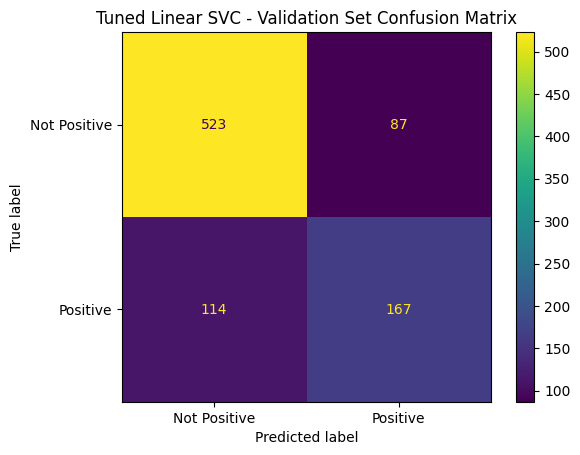

___VS___

Tuned MLP Classifier Results
Best MLP Classifier Hyperparameters: {'mlpc__activation': 'relu', 'mlpc__hidden_layer_sizes': (100,), 'mlpc__max_iter': 500, 'mlpc__solver': 'adam', 'tfidf__max_df': 0.85, 'tfidf__max_features': 1250, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True}
Tuned MLP Classifier Train Cross-Validation Score: 0.7114
Validation Set Accuracy: 0.7295


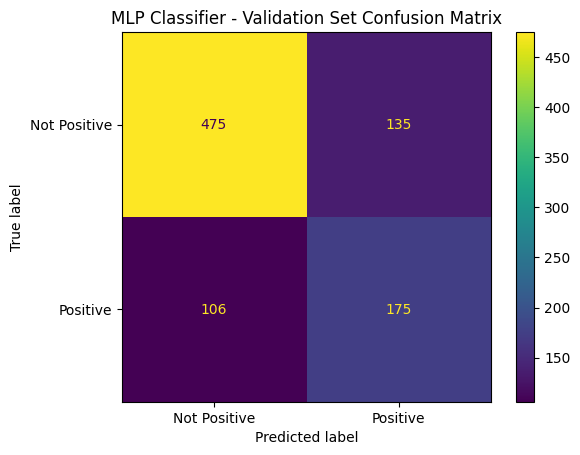

/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [72]:
MLPC_pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mlpc', MLPClassifier(random_state=24))])

MLPC_param_grid1 = {
    'tfidf__max_features': [1250],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [0.001],
    'tfidf__max_df': [0.85],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'mlpc__max_iter': [500, 600],
    'mlpc__hidden_layer_sizes': [(50,), (100,)],
    'mlpc__activation': ['relu'],
    'mlpc__solver': ['adam']}

MLPC_grid_search1 = GridSearchCV(
    MLPC_pipeline1,
    MLPC_param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

MLPC_grid_search1.fit(X_train_str, y_train)

MLPC_best_train_cv_score = MLPC_grid_search1.best_score_

MLPC_best_model = MLPC_grid_search1.best_estimator_

y_val_pred = MLPC_best_model.predict(X_val_str)

MLPC_val_accuracy = accuracy_score(y_val, y_val_pred)

MLPC_best_params = MLPC_grid_search1.best_params_

print("Previous Best Model Results: Tuned Linear SVC")
print(f"Best Linear SVC Train Cross-Validation Score: {LSVC_best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {LSVC_val_accuracy:.4f}\n")
Tuned_LSVC_matrix.plot()
plt.title("Tuned Linear SVC - Validation Set Confusion Matrix")
plt.show()

print("___VS___\n")

print("Tuned MLP Classifier Results")
print(f"Best MLP Classifier Hyperparameters: {MLPC_best_params}")
print(f"Tuned MLP Classifier Train Cross-Validation Score: {MLPC_best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {MLPC_val_accuracy:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
Tuned_MLPC_matrix = ConfusionMatrixDisplay(cm_val, display_labels=['Not Positive', 'Positive'])
Tuned_MLPC_matrix.plot()
plt.title("MLP Classifier - Validation Set Confusion Matrix")
plt.show()

## Model Results

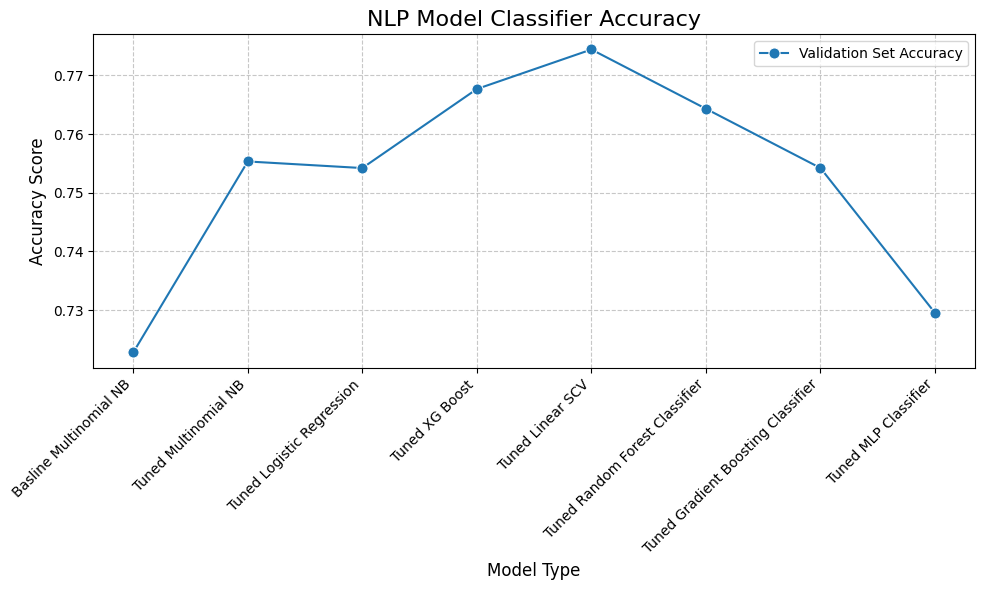

In [89]:
model_results= [('Basline Multinomial NB', BMNB_val_accuracy),
                ('Tuned Multinomial NB', MNB_val_accuracy),
                ('Tuned Logistic Regression', LR_val_accuracy),
                ('Tuned XG Boost', val_accuracy_xgb),
                ('Tuned Linear SCV', LSVC_val_accuracy),
                ('Tuned Random Forest Classifier', RF_val_accuracy),
                ('Tuned Gradient Boosting Classifier', GB_val_accuracy),
                ('Tuned MLP Classifier', MLPC_val_accuracy)]

model_names, accuracies = zip(*model_results)

df_scores = pd.DataFrame({
    'Model Type': model_names,
    'Accuracy Score': accuracies})

plt.figure(figsize=(10, 6))
sns.lineplot(x='Model Type', y='Accuracy Score', data=df_scores, marker='o', 
             markersize=8, label='Validation Set Accuracy')

plt.title('NLP Model Classifier Accuracy', fontsize=16)
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

## Final Test

Final Test Set Accuracy (Tuned Linear SVC Model): 0.7410


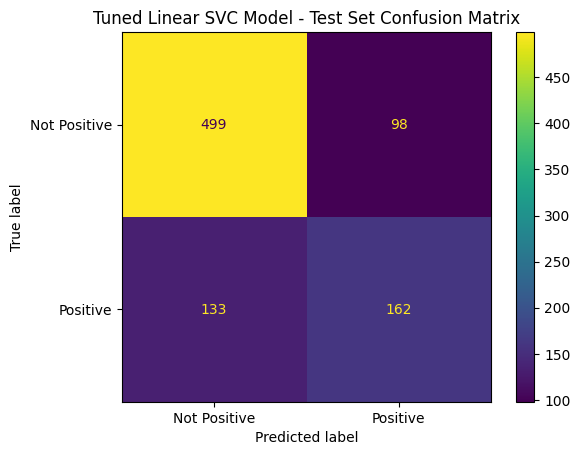

In [111]:
SVC_line = Pipeline([
    ('tfidf', TfidfVectorizer(max_features= 3500,
                              ngram_range= (1, 1),
                              min_df= 0.0,
                              max_df= 0.95, 
                              use_idf= True,
                              stop_words= None,
                              sublinear_tf= True)),
    ('LSVC', LinearSVC(random_state=24,
                      C= 1,
                      penalty= 'l2',
                      loss= 'squared_hinge',
                      tol= 1e-1))])


SVC_line.fit(X_train_str, y_train)

y_test_pred_SVC = SVC_line.predict(X_test_str)
test_accuracy_SVC = accuracy_score(y_test, y_test_pred_SVC)
cm_test_SVC = confusion_matrix(y_test, y_test_pred_SVC)

print(f"Final Test Set Accuracy (Tuned Linear SVC Model): {test_accuracy_SVC:.4f}")
Test_SVC_Matrix = ConfusionMatrixDisplay(cm_test_SVC, display_labels=['Not Positive', 'Positive'])
Test_SVC_Matrix.plot()
plt.title("Tuned Linear SVC Model - Test Set Confusion Matrix")
plt.show()

Final Test Set Accuracy (Tuned Linear SVC Model): 0.7410

Classification Report (Tuned Linear SVC Model):
              precision    recall  f1-score   support

Not Positive       0.79      0.84      0.81       597
    Positive       0.62      0.55      0.58       295

    accuracy                           0.74       892
   macro avg       0.71      0.69      0.70       892
weighted avg       0.73      0.74      0.74       892



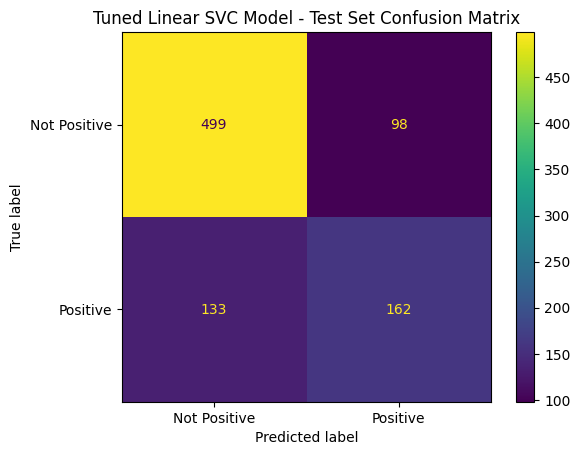

In [163]:
SVC_line = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3500,
                              ngram_range=(1, 1),
                              min_df=0.0,
                              max_df=0.95, 
                              use_idf=True,
                              stop_words=None,
                              sublinear_tf=True)),
    ('LSVC', LinearSVC(random_state=24,
                       C=1,
                       penalty='l2',
                       loss='squared_hinge',
                       tol=1e-1))])

SVC_line.fit(X_train_str, y_train)

y_test_pred_SVC = SVC_line.predict(X_test_str)
test_accuracy_SVC = accuracy_score(y_test, y_test_pred_SVC)
cm_test_SVC = confusion_matrix(y_test, y_test_pred_SVC)

print(f"Final Test Set Accuracy (Tuned Linear SVC Model): {test_accuracy_SVC:.4f}")
print("\nClassification Report (Tuned Linear SVC Model):")
print(classification_report(y_test, y_test_pred_SVC, target_names=['Not Positive', 'Positive']))

Test_SVC_Matrix = ConfusionMatrixDisplay(cm_test_SVC, display_labels=['Not Positive', 'Positive'])
Test_SVC_Matrix.plot()
plt.title("Tuned Linear SVC Model - Test Set Confusion Matrix")
plt.show()

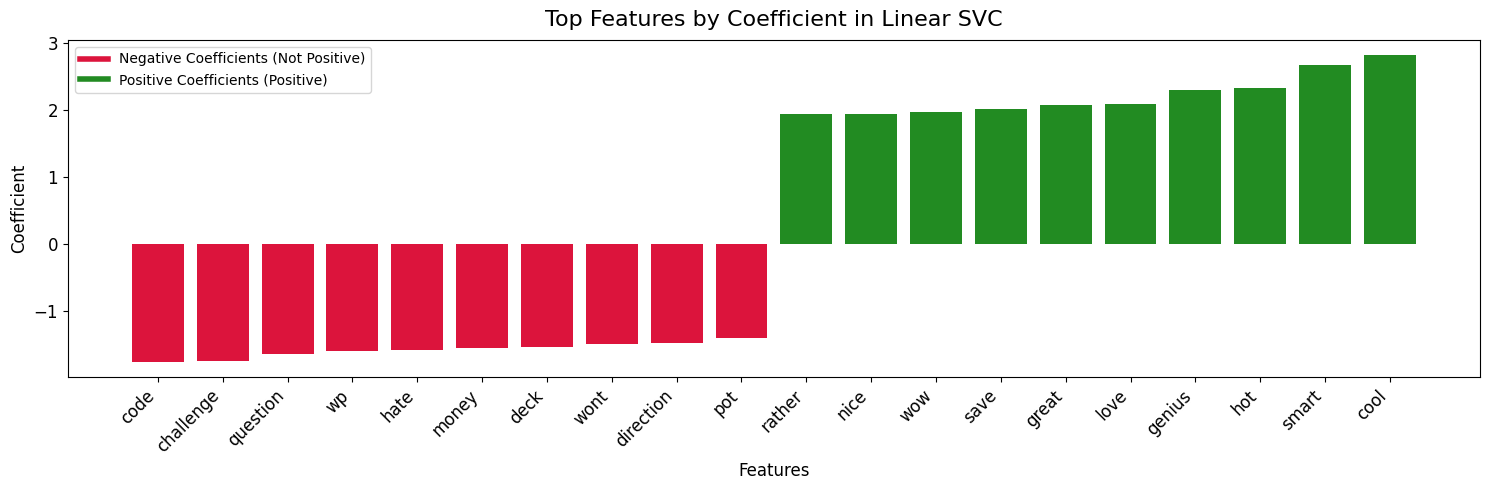

In [155]:
def top_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ["crimson" if c < 0 else 'forestgreen' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(2 * top_features), feature_names[top_coefficients], rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Coefficient', fontsize=12)
    plt.title('Top Features by Coefficient in Linear SVC', fontsize=16, pad=10)
    
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='crimson', lw=4, 
                              label='Negative Coefficients (Not Positive)'),
                       Line2D([0], [0], color='forestgreen', lw=4, 
                              label='Positive Coefficients (Positive)')]
    
    plt.legend(handles=legend_elements, loc='best', fontsize=10)
    
    plt.tight_layout()
    plt.show()


top_coefficients(SVC_line['LSVC'], SVC_line['tfidf'].get_feature_names_out(), top_features=10)